# Dataset和DataLoader简介

根据网上查的资料总结下dataset，dataloader等的用法。参考资料有：[Pytorch数据读取(Dataset, DataLoader, DataLoaderIter)](https://zhuanlan.zhihu.com/p/30934236),[一文弄懂Pytorch的DataLoader, DataSet, Sampler之间的关系](https://www.cnblogs.com/marsggbo/p/11308889.html),[PyTorch 中自定义数据集的读取方法小结](https://www.pytorchtutorial.com/pytorch-custom-dataset-examples/)

首先在使用Pytorch构建和训练模型的过程中，经常需要把原始数据（图片、文本等）转换为张量的格式。对于小数据集，我们可以手动导入，但是在深度学习中，数据集往往是比较大的，这时pytorch的数据导入功能便发挥了作用，Pytorch导入数据主要依靠 torch.utils.data.DataLoader和 torch.utils.data.Dataset这两个类来完成，并采用以下步骤完成最终的数据读取。

## pytorch输入数据pipline“三步走”策略

一般pytorch的数据加载到模型的操作顺序如下：

1、创建一个 Dataset 对象，必须实现 __len__() ，__getitem__() 两个方法，会用到 transform 对数据进行扩充；

2、创建一个 DataLoader 对象，对 Dataset 对象进行迭代的，一般不需要事先实现里面其他方法了；

3、循环遍历DataLoader对象，将img，label 加载到模型中训练。

注：采样器Sampler、Dataset、DataLoader 这三个类均在 torch.utils.data 中定义，简介代码如下：

```python
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
 
dataset = MyDataset() # 第一步：构建 Dataset 对象
dataloader = DataLoader(dataset) # 第二步：通过Dataloader来构建迭代对象
 
num_epoches = 100
for epoch in range(num_epoches):
    for i, data in enumerate(dataloader):
        # 训练代码
```
        

数据集遍历一般化流程：

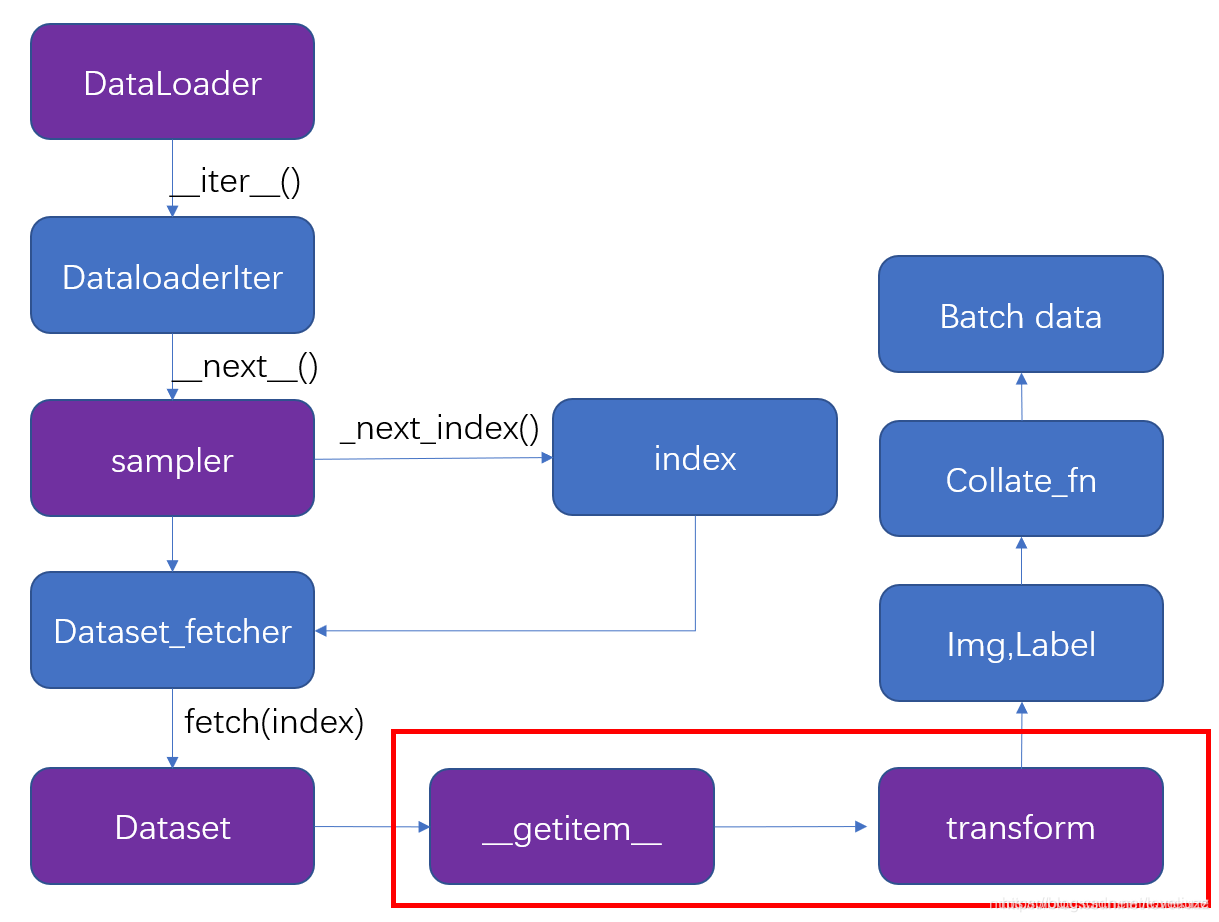

for i, data in enumerate(dataloader):  会调用dataloader 的 __iter__() 方法，产生了一个DataLoaderIter（迭代器），这里判断使用单线程还是多线程，调用 DataLoaderIter 的 __next__() 方法来得到 batch data 。在__next__() 方法中使用 __next_index()方法调用sampler（采样器）获得index索引，接着通过 Dataset_fetcher 的 fetch() 方法根据index（索引）调用dataset的 __getitem__() 方法，然后用 collate_fn 把它们打包成batch。当数据读完后， __next__() 抛出一个 StopIteration 异常，for循环结束，dataloader 失效。


## Dataset

torch.utils.data.Dataset是一个抽象类, 自定义的Dataset需要继承它并且实现两个成员方法:

- getitem()
- len()

第一个最为重要, 即每次怎么读数据，比如对于一个图片：

In [1]:
def __getitem__(self, index):
    img_path, label = self.data[index].img_path, self.data[index].label
    img = Image.open(img_path)

    return img, label

可以看到，img是模型训练的输入数据，label是模型训练的输出数据。

第二个比较简单, 就是返回整个数据集的长度，比如：

In [2]:
def __len__(self):
    return len(self.data)

## DataLoader 与 DataLoaderIter

torch.utils.data.DataLoader类定义为:

class torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)

可以看到, 主要参数有这么几个:

- dataset : 即上面自定义的dataset.
- collate_fn: 这个函数用来打包batch, 后面详细讲.
- num_worker: 非常简单的多线程方法, 只要设置为>=1, 就可以多线程预读数据啦.

这个类一共干了两件事:

定义了一堆成员变量, 到时候赋给torch.utils.data.dataloader.DataLoaderIter
然后有一个iter() 函数, 把自己 "装进" DataLoaderIter 里面.

def __iter__(self):
    return DataLoaderIter(self)

现在再自上而下理解下，首先看看 DataLoaderIter.next 的源码：

In [3]:
class DataLoaderIter(object):
    ...

    def __next__(self):
        if self.num_workers == 0:  
            indices = next(self.sample_iter)  # Sampler
            batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset
            if self.pin_memory:
                batch = _utils.pin_memory.pin_memory_batch(batch)
            return batch

稍微解读下这段代码：

首先 indices = next(self.sample_iter) 这句，假设我们的数据是一组图像，每一张图像对应一个index，那么如果我们要读取数据就只需要对应的index即可，即代码中的indices,而选取index的方式有多种，有按顺序的，也有乱序的，所以这个工作需要Sampler完成，所以DataLoader和Sampler在这里产生了关系。说白点，就是sampler去选择要哪些数据，假如指定了shuffle=True，那就不必再自己定义sampler了，就是直接打乱取样了，indices就会被shuffle好的。

然后Dataset和DataLoader在什么时候产生关系呢？就是这句：“batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset”。[self.dataset[i] for i in indices] 将选中的数据集拼到一个list里面，然后利用 collate_fn 将这个list的数据组织成想要的 batch 的形式。collate_fn 可以使用默认的，也可以自己写一个。default_collate （在torch.utils.data._utils.collate.py中） 注释是：r"""Puts each data field into a tensor with outer dimension batch size""" ， 也就是说batch_size 是最外部的维度。

所以有这样的关系图：

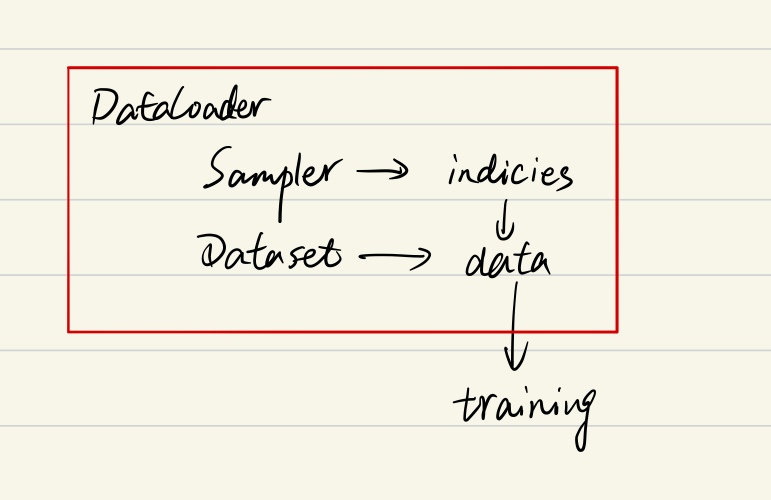

综上，Dataset和DatasetLoader及数据集切分的基本使用流程如下：

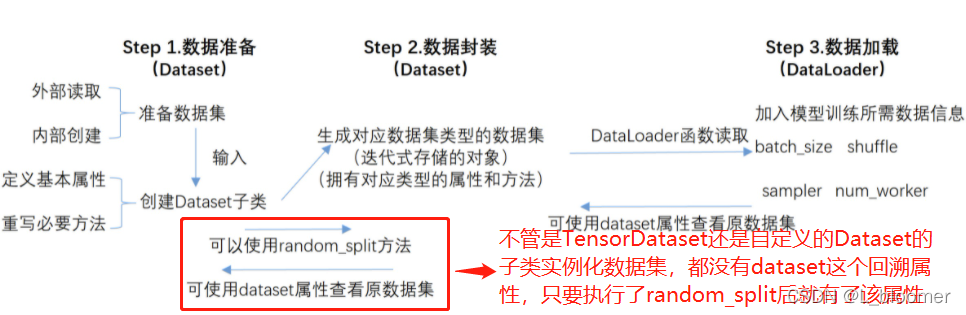